In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [3]:
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

img_size = (48, 48)
batch_size = 64
num_classes = 7  # angry, disgust, fear, happy, neutral, sad, surprise

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # split train into train/val
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    batch_size=batch_size,
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size,
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*img_size,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-06 04:55:00.425084: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 179s 484ms/step - accuracy: 0.1720 - loss: 2.6982 - val_accuracy: 0.0970 - val_loss: 3.3115
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 217ms/step - accuracy: 0.1936 - loss: 2.0398 - val_accuracy: 0.2127 - val_loss: 1.9032
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 217ms/step - accuracy: 0.1968 - loss: 1.9407 - val_accuracy: 0.2120 - val_loss: 1.9036
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 216ms/step - accuracy: 0.2175 - loss: 1.8846 - val_accuracy: 0.2493 - val_loss: 1.8704
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 217ms/step - accuracy: 0.2351 - loss: 1.8723 - val_accuracy: 0.2419 - val_loss: 1.8448
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 77s 216ms/step - accuracy: 0.2429 - loss: 1.8494 - val_accuracy: 0.2298 - val_loss: 1.8497
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.2546 - loss: 1.8165 - val_accuracy: 0.3083 - val_loss: 1.7750
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 77s 215ms/step - accuracy: 0.2825 - loss: 

In [8]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.4406 - loss: 1.4432
Test Accuracy: 0.4741


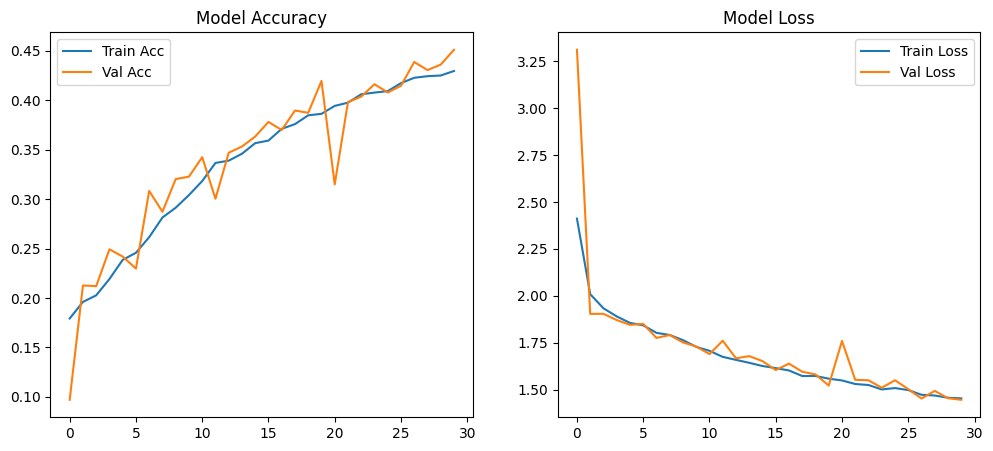

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [1]:
model.save("/kaggle/working/emotion_detector.keras")
print("Model saved as emotion_detector.keras")

NameError: name 'model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Predicted emotion: happy


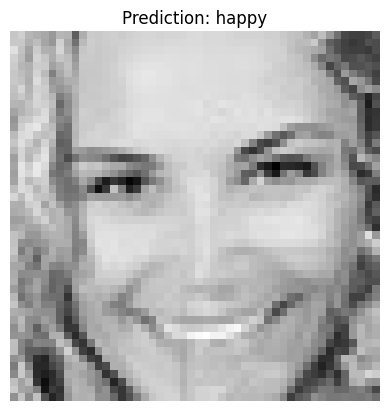

In [11]:
from tensorflow.keras.preprocessing import image

labels = list(train_gen.class_indices.keys())

def predict_emotion(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    emotion = labels[np.argmax(pred)]
    print(f"Predicted emotion: {emotion}")
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {emotion}")
    plt.axis('off')
    plt.show()

# Example test
predict_emotion("/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg")